**CPU Implementation**

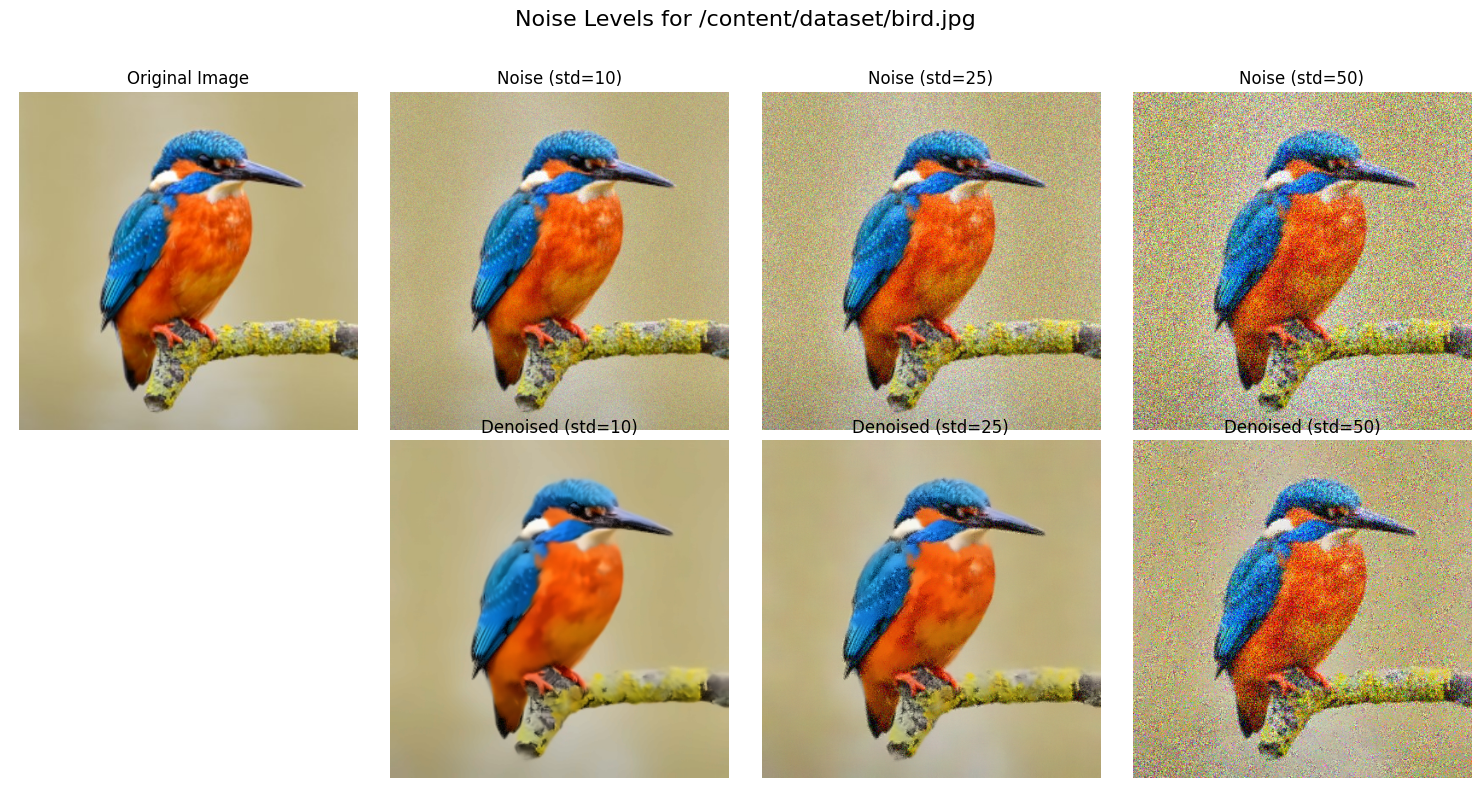

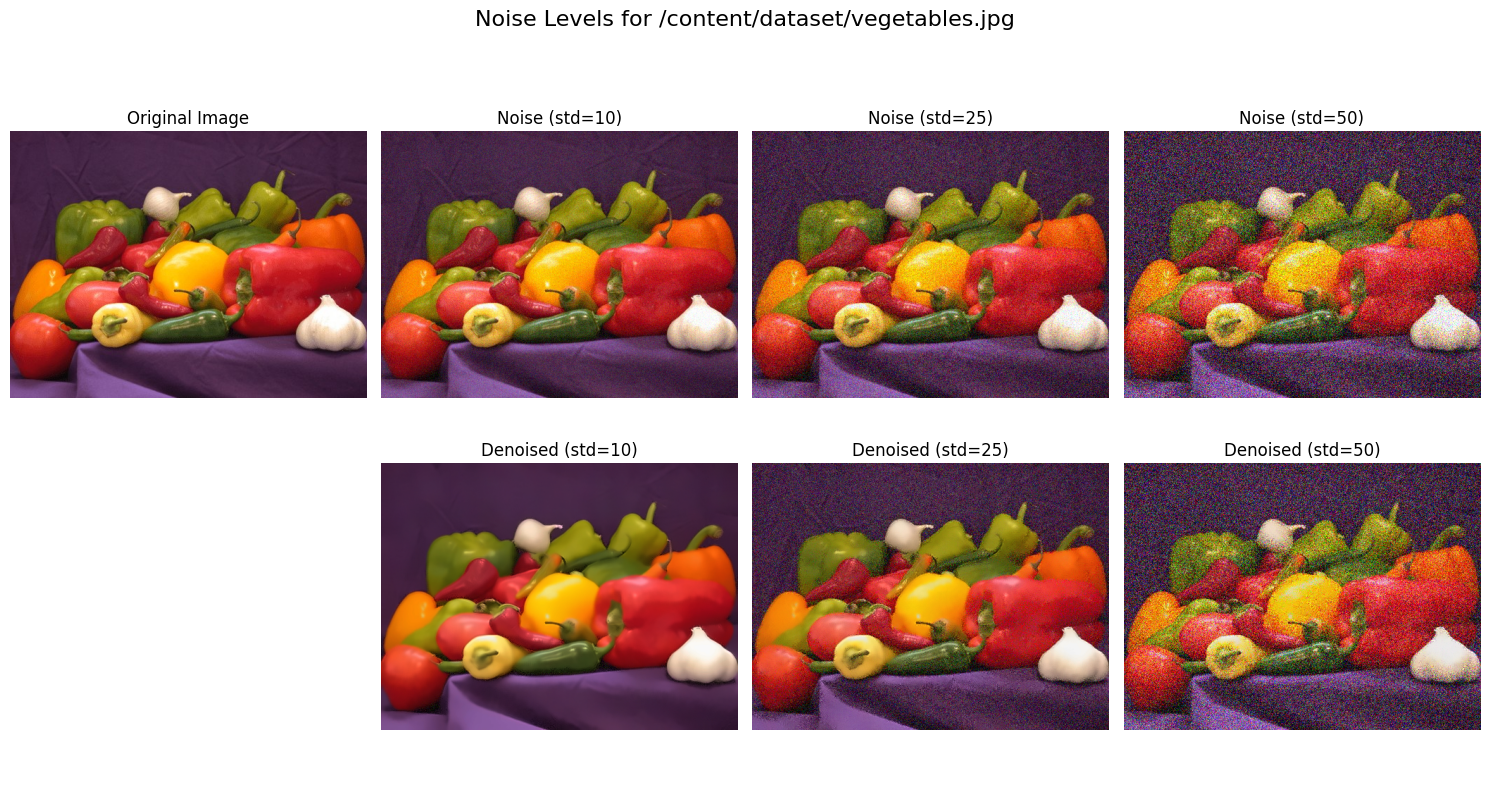

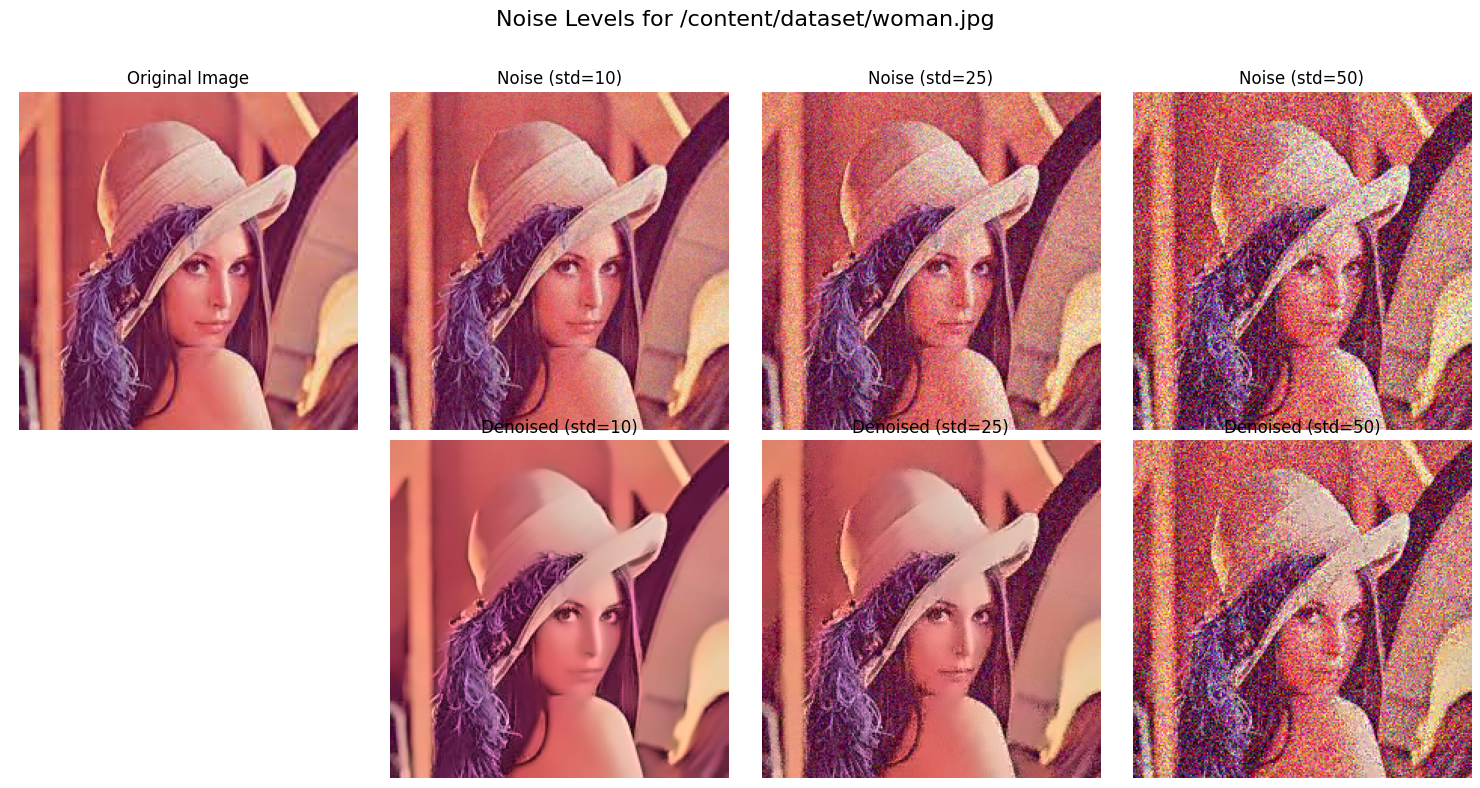

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Paths to the images
image_paths = [
    './material/bird.jpg',
    './material/vegetables.jpg',
    './material/woman.jpg'
]

# Different Gaussian noise intensities (standard deviations)
noise_levels = [10, 25, 50]

# Function to add Gaussian noise
def add_gaussian_noise(image, mean, std_dev):
    gauss = np.random.normal(mean, std_dev, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + gauss
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Function to denoise an image using OpenCV's Non-Local Means
def nlm_denoise(image, h=10, h_for_color_components=10, template_window_size=7, search_window_size=21):
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        denoised_image = cv2.fastNlMeansDenoisingColored(image, None, h, h_for_color_components,
                                                         template_window_size, search_window_size)
    else:  # Grayscale image
        denoised_image = cv2.fastNlMeansDenoising(image, None, h, template_window_size, search_window_size)
    return denoised_image

# Process each image with different noise levels
for path in image_paths:
    # Load the image
    image = cv2.imread(path)

    # Set up figure dimensions based on noise levels
    fig, axes = plt.subplots(2, len(noise_levels) + 1, figsize=(15, 8))
    fig.suptitle(f"Noise Levels for {path}", fontsize=16)

    # Display original image
    axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')  # Leave bottom left empty for alignment

    # Apply different intensities of Gaussian noise and denoise
    for i, std_dev in enumerate(noise_levels):
        # Add noise
        noisy_image = add_gaussian_noise(image, mean=0, std_dev=std_dev)
        # Denoise the noisy image
        denoised_image = nlm_denoise(noisy_image, h=10, h_for_color_components=10, template_window_size=7, search_window_size=21)

        # Plot noisy images in the top row
        axes[0, i + 1].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
        axes[0, i + 1].set_title(f"Noise (std={std_dev})")
        axes[0, i + 1].axis('off')

        # Plot denoised images in the bottom row
        axes[1, i + 1].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
        axes[1, i + 1].set_title(f"Denoised (std={std_dev})")
        axes[1, i + 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add some space for the main title
    plt.show()

***Image_Denoising***


In [ ]:
from numba import jit

# Function to preprocess neighbors (small_window x small_window) for each pixel
@jit(nopython=True, cache=True)
def findAllNeighbors(padImg, small_window, big_window, h, w):
    smallWidth = small_window // 2
    bigWidth = big_window // 2
    neighbors = np.zeros((padImg.shape[0], padImg.shape[1], small_window, small_window))

    for i in range(bigWidth, bigWidth + h):
        for j in range(bigWidth, bigWidth + w):
            neighbors[i, j] = padImg[(i - smallWidth):(i + smallWidth + 1), (j - smallWidth):(j + smallWidth + 1)]

    return neighbors

# Function to calculate the weighted average value (Ip) for each pixel
@jit(nopython=True, cache=True)
def evaluateNorm(pixelWindow, neighborWindow, Nw):
    Ip_Numerator, Z = 0, 0
    for i in range(neighborWindow.shape[0]):
        for j in range(neighborWindow.shape[1]):
            q_window = neighborWindow[i, j]
            q_x, q_y = q_window.shape[0] // 2, q_window.shape[1] // 2
            Iq = q_window[q_x, q_y]
            w = np.exp(-1 * ((np.sum((pixelWindow - q_window) ** 2)) / Nw))
            Ip_Numerator += (w * Iq)
            Z += w
    return Ip_Numerator / Z

def show_gray(img, title=""):
    plt.imshow(img, cmap='gray')
    plt.title(title)

In [ ]:
!pip install scikit-image
from skimage.util import random_noise
import numpy as np

class noisy_system():
    def example(self, img, **kwargs):
        noisy_image = random_noise(img, **kwargs)
        noisy_image = np.uint8(noisy_image * 255)
        return noisy_image

    def create_gaussian_noise(self, img, mean=0, var=0.01):
        img = img / 255
        result = img.copy()
        gauss = np.random.normal(mean, var ** 0.5, img.shape)
        result = result + gauss
        result = np.clip(result, 0, 1)
        result = np.uint8(result * 255)
        return result

In [ ]:
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim

def MSE(image1,image2):
  """
  Mean Squared Error
  :param image1: image1
  :param image2: image2
  :rtype: float
  :return: MSE value
  """

  # Calculating the Mean Squared Error
  mse = np.mean(np.square(image1.astype(float) - image2.astype(float)))

  return mse

def SSIM(image1,image2):

  # Calculating the Mean Squared Error
  ssim_value, _ = ssim(image1, image2, full=True, data_range=1)

  return ssim_value

def PSNR(image1, image2, peak=255):
  """
  Peak signal-to-noise ratio
  :param image1: image1
  :param image2: image2
  :param peak: max value of pixel 8-bit image (255)
  :rtype: float
  :return: PSNR value
  """

  # Calculating the Mean Squared Error
  mse = MSE(image1,image2)

  # Calculating the Peak Signal Noise Ratio
  psnr = 10*np.log10(peak**2/mse)

  return psnr

In [ ]:
class NLMeans():
  """
  Non Local Means, donot change the solve function. You may add any other class
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """
  def example(self,img,**kwargs):
    denoised_image = cv2.fastNlMeansDenoising(img,**kwargs)
    return denoised_image

  def solve(self,img,h=30,small_window=7,big_window=21):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param h: sigma h (as mentioned in the paper)
    :param small_window: size of small window
    :param big_window: size of big window
    :rtype: uint8 (w,h)
    :return: solved image
    """

    # Padding the original image with reflect mode
    padImg = np.pad(img,big_window//2,mode='reflect')

    return self.NLM(padImg,img,h,small_window,big_window)

  @staticmethod
  @jit(nopython = True, cache = True)
  def NLM(padImg, img, h, small_window, big_window):
    # Calculating neighborhood window
    Nw = (h**2)*(small_window**2)

    # Getting dimensions of the image
    h,w = img.shape

    # Initializing the result
    result = np.zeros(img.shape)

    # Finding width of the neighbor window and padded image from the center pixel
    bigWidth = big_window//2
    smallWidth = small_window//2

    # Preprocessing the neighbors of each pixel
    neighbors = findAllNeighbors(padImg, small_window, big_window, h, w)

    # NL Means algorithm
    for i in range(bigWidth, bigWidth + h):
        for j in range(bigWidth, bigWidth + w):
            # (small_window x small_window) array for pixel p
            pixelWindow = neighbors[i,j]

            # (big_window x big_window) pixel neighborhhod array for pixel p
            neighborWindow = neighbors[(i - bigWidth):(i + bigWidth + 1) , (j - bigWidth):(j + bigWidth + 1)]

            # Calculating Ip using pixelWindow and neighborWindow
            Ip = evaluateNorm(pixelWindow, neighborWindow, Nw)

            # Cliping the pixel values to stay between 0-255
            result[i - bigWidth, j - bigWidth] = max(min(255, Ip), 0)

    return result

(CV2 Denoise) Time taken: 0.26s

(Implemented Denoise) Time taken: 22.61s

Statistics:
Noisy   => GSN -> PSNR: 20.18 | SSIM: 0.18
CV2 => GSN -> PSNR: 30.70 | SSIM: 0.43
Implemented function => GSN -> PSNR: 30.64 | SSIM: 0.43



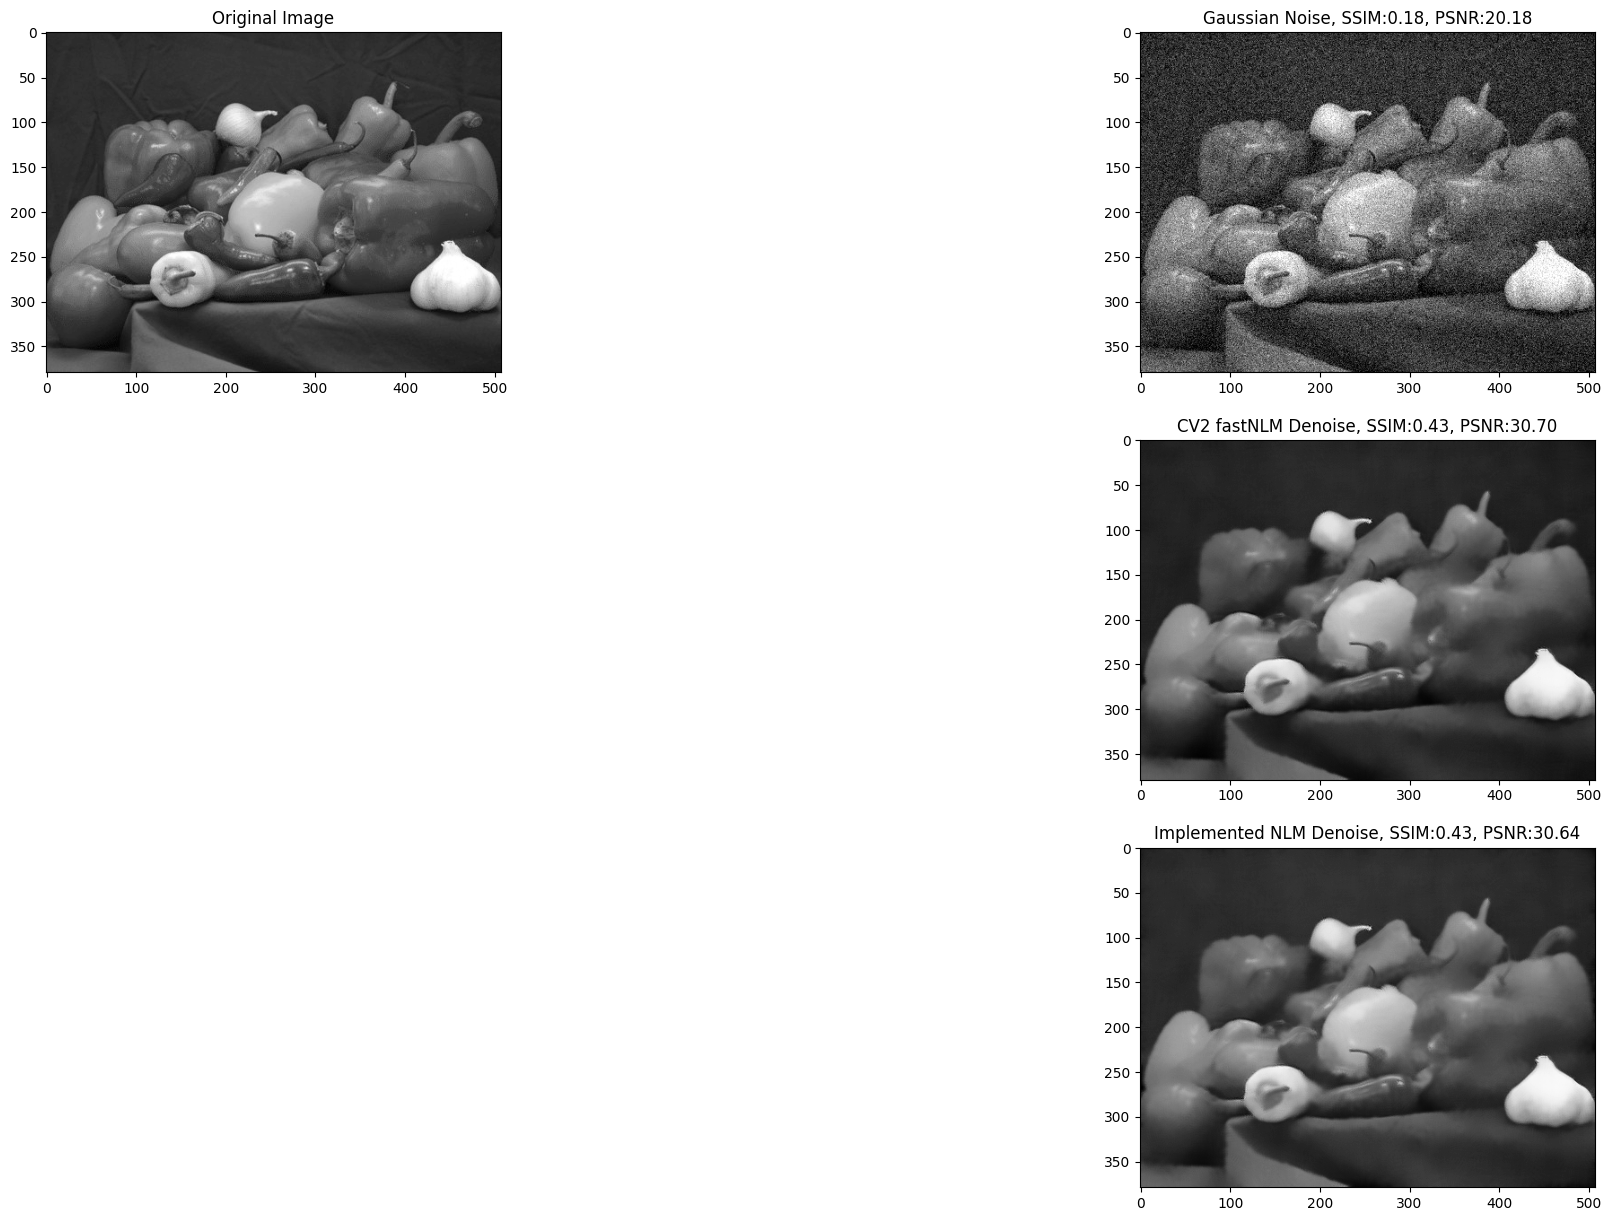

In [ ]:
#@title Grader { vertical-output: true, display-mode: "form" }
image_name = 'vegetables' # @param ["bird", "vegetables", "woman"]
# salt_and_paper_h =   36#@param {type:"integer"}
input_h =         27#@param {type:"integer"}

# %%timeit
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

noise_maker               = noisy_system()
denoiser                    = NLMeans()
image                       = cv2.imread(f"/content/dataset/{image_name}.jpg")
image                       = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# salt_and_pepper_example     = noise_maker.example(image.copy(),mode="s&p")
gaussian_example            = noise_maker.example(image.copy(),mode="gaussian")

start = time.time()

# salt_and_pepper_denoise     = denoiser.example(salt_and_pepper_example.copy(),h=salt_and_paper_h)
gaussian_denoise            = denoiser.example(gaussian_example.copy(),h=input_h)

end = time.time()
print(f"(CV2 Denoise) Time taken: {end-start:.2f}s\n")

start = time.time()

# my_salt_and_pepper_denoise  = denoiser.solve(salt_and_pepper_example.copy(),h=salt_and_paper_h)
my_gaussian_denoise         = denoiser.solve(gaussian_example.copy(),h=input_h)

end = time.time()
print(f"(Implemented Denoise) Time taken: {end-start:.2f}s\n")

print("Statistics:")
# print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
# print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | SSIM: {SSIM(gaussian_example,image):.2f}")
# print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"CV2 => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | SSIM: {SSIM(gaussian_denoise,image):.2f}")
# print(f"My Func => SNP -> PSNR: {PSNR(my_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_salt_and_pepper_denoise,image):.2f}")
print(f"Implemented function => GSN -> PSNR: {PSNR(my_gaussian_denoise,image):.2f} | SSIM: {SSIM(my_gaussian_denoise,image):.2f}\n")

plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
show_gray(image,"Original Image")
# plt.subplot(3,3,2)
# show_gray(salt_and_pepper_example,
          # f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(3,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, SSIM:{SSIM(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
# plt.subplot(3,3,5)
# show_gray(salt_and_pepper_denoise,
          # f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,6)
show_gray(gaussian_denoise,
          f"CV2 fastNLM Denoise, SSIM:{SSIM(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
# plt.subplot(3,3,8)
# show_gray(my_salt_and_pepper_denoise,
          # f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,9)
show_gray(my_gaussian_denoise,
          f"Implemented NLM Denoise, SSIM:{SSIM(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
plt.show()

**GPU Implementation with CUDA**

In [1]:
def non_local_means_filter(img, k_size=7, s_size=101, beta=0.1, device = 'cpu'):
    img = img.to(device)
    pad = s_size // 2
    img_pad = torch.nn.functional.pad(img, (pad, pad, pad, pad), mode='reflect')
    out = torch.zeros_like(img)
    w_sum = torch.zeros_like(img)

    for dx in range(-pad, pad + 1):
        for dy in range(-pad, pad + 1):
            shifted = img_pad[:, :, pad + dx : pad + dx + img.size(2), pad + dy : pad + dy + img.size(3)]
            diff = (img - shifted) ** 2
            w = torch.exp(-diff / (beta ** 2))
            out += w * shifted
            w_sum += w

    out /= w_sum
    return out

GPU Run time for/content/dataset/bird.jpg :  1.256054401397705
Run time with GPU : 3.7682807445526123


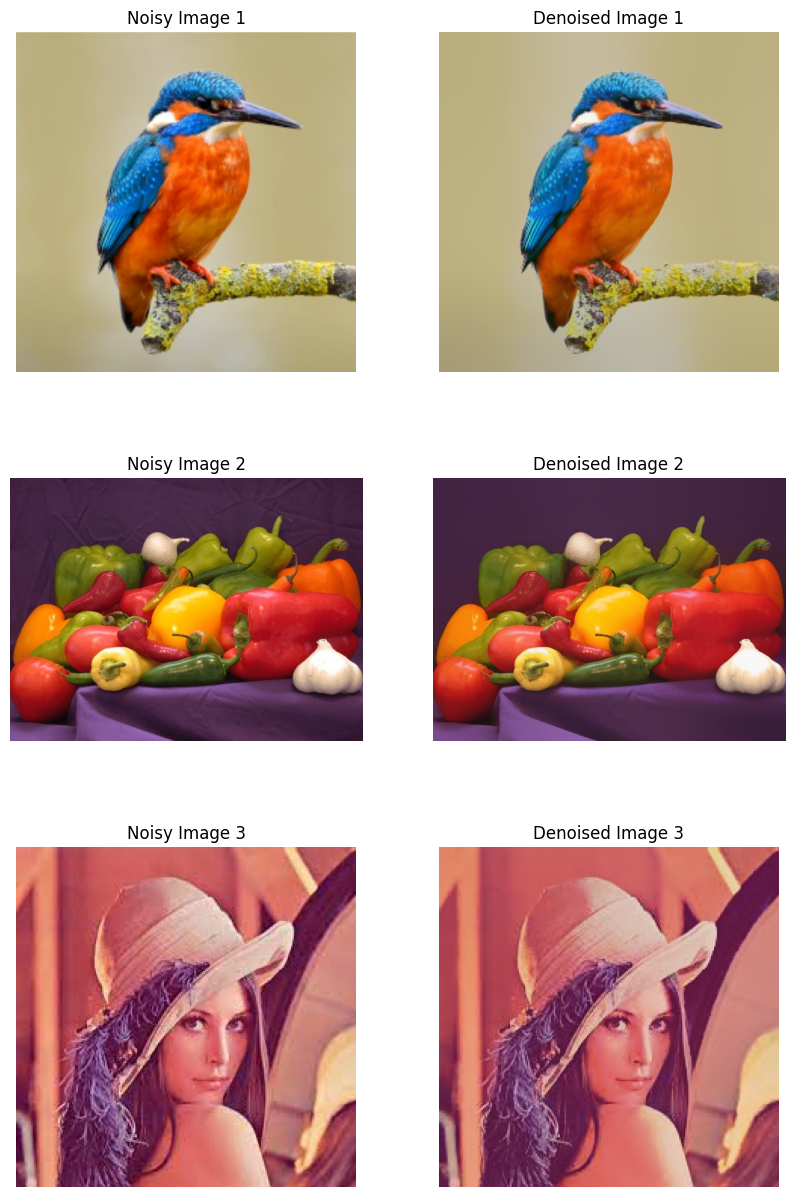

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load images from paths
image_paths = [
    './material/bird.jpg',
    './material/vegetables.jpg',
    './material/woman.jpg'
]

# Dictionary to store results
noisy_images_np = {}
denoised_images_np = {}

# Start timing
start_time = time.time()
torch.cuda.synchronize()

# Loop through images, process each, and store results
for i, image_path in enumerate(image_paths):
    # Load image and apply transformations
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Apply denoising (replace non_local_means_filter with your actual function)
    denoised_image_tensor = non_local_means_filter(image_tensor, device='cuda').cuda()

    # Convert to numpy format for displaying
    noisy_images_np[i] = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    denoised_images_np[i] = denoised_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    if(i==0):
      print("GPU Run time for" + image_path + ' : ', time.time() - start_time)
# Measure GPU time
gpu_time = time.time() - start_time

# Plot results
fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, 15))

for i in range(len(image_paths)):
    axes[i, 0].imshow(noisy_images_np[i], cmap='gray')
    axes[i, 0].set_title(f"Noisy Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(denoised_images_np[i], cmap='gray')
    axes[i, 1].set_title(f"Denoised Image {i+1}")
    axes[i, 1].axis('off')

print(f'Run time with GPU : {gpu_time}')
plt.show()
